In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import aiohttp
import nest_asyncio
import asyncio
from time import time
from concurrent.futures import ProcessPoolExecutor

nest_asyncio.apply()

In [3]:
# Путь к данным
DATA_PATH = 'temperature_data.csv'

# Загрузка данных
data = pd.read_csv(DATA_PATH)
data['timestamp'] = pd.to_datetime(data['timestamp'])

print("Пример данных:")
display(data.head())

# Проверка отсутствующих значений
print("Пропущенные значения:")
print(data.isnull().sum())


Пример данных:


,city,timestamp,temperature,season
0,New York,2010-01-01,-0.424866,winter
1,New York,2010-01-02,-6.931198,winter
2,New York,2010-01-03,-4.317589,winter
3,New York,2010-01-04,-4.074663,winter
4,New York,2010-01-05,-7.940252,winter


Пропущенные значения:
city           0
timestamp      0
temperature    0
season         0
dtype: int64


In [4]:
# Скользящее среднее и стандартное отклонение
data['rolling_mean'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())
data['rolling_std'] = data.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())


In [5]:
# Выявление аномалий
def is_anomaly(row: pd.Series) -> bool:
    """Проверка строки на аномальность."""
    return (row['temperature'] < row['rolling_mean'] - 2 * row['rolling_std']
            or row['temperature'] > row['rolling_mean'] + 2 * row['rolling_std'])

data['is_anomaly'] = data.apply(is_anomaly, axis=1)

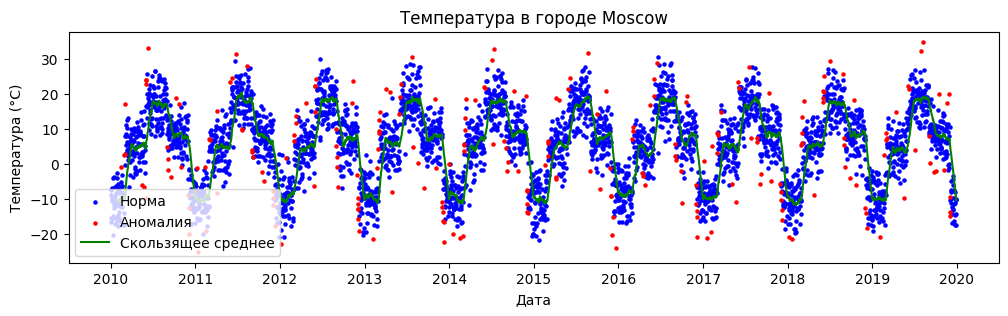

In [8]:
# Визуализация скользящего среднего и аномалий
city = 'Moscow'
not_anomalies = data[(data['city'] == city) & (data['is_anomaly'] == False)]
anomalies = data[(data['city'] == city) & (data['is_anomaly'] == True)]

plt.figure(figsize=(12, 3))
plt.scatter(not_anomalies['timestamp'], not_anomalies['temperature'], s=5, c='blue', label='Норма')
plt.scatter(anomalies['timestamp'], anomalies['temperature'], s=5, c='red', label='Аномалия')
plt.plot(data[data['city'] == city]['timestamp'], data[data['city'] == city]['rolling_mean'], c='green', label='Скользящее среднее')
plt.legend()
plt.title(f'Температура в городе {city}')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.show()

In [9]:
# Вычисление статистик для каждого города и сезона
stats = {}
for city in data['city'].unique():
    stats[city] = {}
    for season in data['season'].unique():
        stats[city][season] = {
            'mean': data[(data['city'] == city) & (data['season'] == season)]['temperature'].mean(),
            'std': data[(data['city'] == city) & (data['season'] == season)]['temperature'].std()
        }

print("Статистика для Москвы:")
display(pd.DataFrame(stats['Moscow']))

Статистика для Москвы:


,winter,spring,summer,autumn
mean,-9.807245,5.024493,18.037525,7.851087
std,4.948382,5.153150,5.020153,5.005479


In [10]:
# Эксперимент 1: Анализ без параллельности
def analyze_data_base() -> pd.DataFrame:
    """Анализ данных без параллельности."""
    df = pd.read_csv(DATA_PATH)
    df['rolling_mean'] = df.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).mean())
    df['rolling_std'] = df.groupby('city')['temperature'].transform(lambda x: x.rolling(window=30).std())
    df['is_anomaly'] = df.apply(is_anomaly, axis=1)
    return df

start = time()
_ = analyze_data_base()
print(f"Анализ без параллельности: {time() - start:.2f} секунд")

Анализ без параллельности: 1.13 секунд


In [11]:
# Эксперимент 2: Анализ с параллельной обработкой
def analyze_city(city):
    """Анализ данных для одного города."""
    city_data = data[data['city'] == city].copy()
    city_data['rolling_mean'] = city_data['temperature'].rolling(window=30).mean()
    city_data['rolling_std'] = city_data['temperature'].rolling(window=30).std()
    city_data['is_anomaly'] = city_data.apply(is_anomaly, axis=1)
    return city_data

def analyze_data_parallel():
    with ProcessPoolExecutor() as executor:
        results = executor.map(analyze_city, data['city'].unique())
    return pd.concat(results)

start = time()
_ = analyze_data_parallel()
print(f"Анализ с параллельной обработкой: {time() - start:.2f} секунд")

Анализ с параллельной обработкой: 1.18 секунд


In [16]:
# Сравнение синхронных и асинхронных запросов к API OpenWeatherMap
API_KEY = 'd5c166b2945ec18dd5e8e36de557ae78'
API_URL = 'https://api.openweathermap.org/data/2.5/weather'

def sync_request(city: str) -> float:
    params = {'q': city, 'appid': API_KEY, 'units': 'metric'}
    response = requests.get(API_URL, params=params)
    if response.status_code == 200:  # Успешный HTTP-ответ
        data = response.json()
        if 'main' in data:  # Проверяем наличие ключа
            return data['main']['temp']
        else:
            raise KeyError(f"Ключ 'main' отсутствует в ответе: {data}")
    else:
        raise ValueError(f"Ошибка запроса: {response.status_code}, {response.text}")

# Асинхронный запрос
async def async_request(city: str) -> float:
    params = {'q': city, 'appid': API_KEY, 'units': 'metric'}
    async with aiohttp.ClientSession() as session:
        async with session.get(API_URL, params=params) as response:
            if response.status == 200:  # Успешный HTTP-ответ
                data = await response.json()
                if 'main' in data:  # Проверяем наличие ключа
                    return data['main']['temp']
                else:
                    raise KeyError(f"Ключ 'main' отсутствует в ответе: {data}")
            else:
                raise ValueError(f"Ошибка запроса: {response.status}, {await response.text()}")

# Тест синхронного запроса
try:
    start = time()
    sync_temp = sync_request('Moscow')
    print(f"Синхронный запрос: {time() - start:.4f} секунд, температура: {sync_temp}°C")
except Exception as e:
    print(f"Ошибка синхронного запроса: {e}")

# Тест асинхронного запроса
try:
    start = time()
    async_temp = asyncio.run(async_request('Moscow'))
    print(f"Асинхронный запрос: {time() - start:.4f} секунд, температура: {async_temp}°C")
except Exception as e:
    print(f"Ошибка асинхронного запроса: {e}")

Синхронный запрос: 0.0727 секунд, температура: -1.23°C
Асинхронный запрос: 0.0672 секунд, температура: -1.23°C
